Epoch [1/100], D Loss: -3.872318744659424, G Loss: 1.685843586921692
Epoch [2/100], D Loss: -1.935507893562317, G Loss: -2.747818946838379
Epoch [3/100], D Loss: 4.247136116027832, G Loss: -7.258566379547119
Epoch [4/100], D Loss: 1.2657456398010254, G Loss: 7.666378974914551
Epoch [5/100], D Loss: 2.857639789581299, G Loss: 3.821540355682373
Epoch [6/100], D Loss: -2.771663188934326, G Loss: 13.985979080200195
Epoch [7/100], D Loss: -3.3581020832061768, G Loss: 14.126720428466797
Epoch [8/100], D Loss: -3.0880470275878906, G Loss: 13.822702407836914
Epoch [9/100], D Loss: -2.7022933959960938, G Loss: 13.577086448669434
Epoch [10/100], D Loss: -2.840325355529785, G Loss: 12.560466766357422
Epoch [11/100], D Loss: -3.6499485969543457, G Loss: 10.056644439697266
Epoch [12/100], D Loss: -3.4150285720825195, G Loss: 6.608576774597168
Epoch [13/100], D Loss: 2.2375380992889404, G Loss: -2.7511138916015625
Epoch [14/100], D Loss: 2.747807502746582, G Loss: -1.653200626373291
Epoch [15/100], 

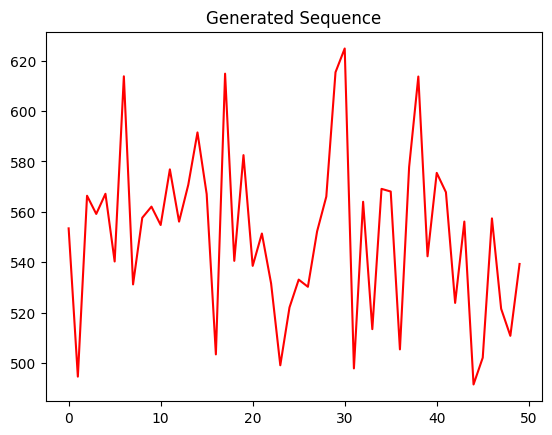

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import spectral_norm
import os

# ------------------------------------------
# Fix CUDA and cuBLAS Issues
# ------------------------------------------
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(False)
torch.backends.cuda.matmul.allow_tf32 = True

# Disable efficient attention kernels
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

# ------------------------------------------
# Data Loading and Preprocessing
# ------------------------------------------
df = pd.read_csv('/content/ADANIPORTS.csv', parse_dates=['Date'])
df = df.sort_values('Date')

if 'Close' not in df.columns:
    raise ValueError("The dataset does not contain a 'Close' column.")

close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(close_prices)

# ------------------------------------------
# Create Sequences
# ------------------------------------------
sequence_length = 10
batch_size = 32
noise_dim = 100

def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

sequences, targets = create_sequences(normalized_prices, sequence_length)
dataset = TensorDataset(sequences, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ------------------------------------------
# Transformer-based Generator (Fixed)
# ------------------------------------------
class TransformerGenerator(nn.Module):
    def __init__(self, noise_dim, d_model=128, num_heads=8, num_layers=4, seq_len=10, num_features=1):
        super(TransformerGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.seq_len = seq_len
        self.num_features = num_features

        self.input_fc = nn.Linear(noise_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(seq_len, d_model))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=num_heads, dropout=0.2, batch_first=True
            ),
            num_layers=num_layers
        )
        self.output_fc = nn.Linear(d_model, num_features)
        self.tanh = nn.Tanh()

    def forward(self, noise):
        batch_size = noise.size(0)
        noise_seq = noise.unsqueeze(1).expand(-1, self.seq_len, -1)
        x = self.input_fc(noise_seq) + self.pos_encoder
        x = self.transformer(x)
        x = self.output_fc(x)
        return self.tanh(x)

# ------------------------------------------
# Transformer-based Discriminator (Fixed)
# ------------------------------------------
class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=4, num_heads=8, dropout=0.2):
        super(TransformerDiscriminator, self).__init__()

        self.embedding = spectral_norm(nn.Linear(input_dim, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = spectral_norm(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

# ------------------------------------------
# Setup
# ------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = TransformerGenerator(noise_dim=noise_dim).to(device)
discriminator = TransformerDiscriminator(input_dim=1).to(device)

learning_rate = 0.00005
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# ------------------------------------------
# Loss Functions (Wasserstein Loss)
# ------------------------------------------
def generator_loss(fake_output):
    return -torch.mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return -(torch.mean(real_output) - torch.mean(fake_output))

# ------------------------------------------
# Gradient Penalty (Fixed)
# ------------------------------------------
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ------------------------------------------
# GAN Training Loop (Fixed)
# ------------------------------------------
# GAN Training Loop (Fixed)
# GAN Training Loop (Fixed)
def train_gan(generator, discriminator, dataloader, num_epochs):
    for epoch in range(num_epochs):
        for real_sequences, _ in dataloader:
            batch_size = real_sequences.size(0)
            real_sequences = real_sequences.to(device)
            noise = torch.randn(batch_size, noise_dim).to(device) * 0.1

            # -------------------------
            # Train Discriminator
            # -------------------------
            d_optimizer.zero_grad()
            fake_sequences = generator(noise)
            real_outputs = discriminator(real_sequences)
            fake_outputs = discriminator(fake_sequences.detach())

            d_loss = discriminator_loss(real_outputs, fake_outputs)
            gradient_penalty = compute_gradient_penalty(discriminator, real_sequences, fake_sequences)
            d_loss += 10 * gradient_penalty

            # Retain graph so that generator can compute gradients
            d_loss.backward(retain_graph=True)
            d_optimizer.step()

            # -------------------------
            # Train Generator
            # -------------------------
            g_optimizer.zero_grad()
            fake_outputs = discriminator(fake_sequences)  # No detach here!
            g_loss = generator_loss(fake_outputs)

            # No need to retain graph since it's last step in forward pass
            g_loss.backward()
            g_optimizer.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# ------------------------------------------
# Train the GAN
# ------------------------------------------
num_epochs = 100
train_gan(generator, discriminator, dataloader, num_epochs)

# ------------------------------------------
# Generate Synthetic Data
# ------------------------------------------
with torch.no_grad():
    test_noise = torch.randn(5, noise_dim).to(device) * 0.1
    generated_sequences = generator(test_noise).cpu().numpy()
    generated_sequences = scaler.inverse_transform(generated_sequences.reshape(-1, 1))

# ------------------------------------------
# Plot Synthetic Data
# ------------------------------------------
plt.plot(generated_sequences[:50], label='Generated Sequence', color='r')
plt.title("Generated Sequence")
plt.show()


In [ ]:
pip install torchsummary


Epoch [1/500], D Loss: 0.5849, G Loss: 16.0934
Epoch [2/500], D Loss: -1.4414, G Loss: 7.5314
Epoch [3/500], D Loss: 0.3903, G Loss: 9.6109
Epoch [4/500], D Loss: -0.7226, G Loss: -14.4349
Epoch [5/500], D Loss: -0.1417, G Loss: 18.8820
Epoch [6/500], D Loss: 0.4984, G Loss: 17.0263
Epoch [7/500], D Loss: 0.1214, G Loss: 5.3411
Epoch [8/500], D Loss: -0.1164, G Loss: -13.6962
Epoch [9/500], D Loss: -1.8874, G Loss: -0.1931
Epoch [10/500], D Loss: -0.1938, G Loss: -20.4438
Epoch [11/500], D Loss: 0.0134, G Loss: -10.8044
Epoch [12/500], D Loss: -2.3749, G Loss: 9.0527
Epoch [13/500], D Loss: -0.7564, G Loss: 15.4448
Epoch [14/500], D Loss: -43.2581, G Loss: 21.6533
Epoch [15/500], D Loss: -45.1601, G Loss: 22.6272
Epoch [16/500], D Loss: -45.6318, G Loss: 22.8512
Epoch [17/500], D Loss: -45.9721, G Loss: 23.0188
Epoch [18/500], D Loss: -46.2605, G Loss: 23.1571
Epoch [19/500], D Loss: -46.5144, G Loss: 23.2898
Epoch [20/500], D Loss: -46.7638, G Loss: 23.4064
Epoch [21/500], D Loss: -46

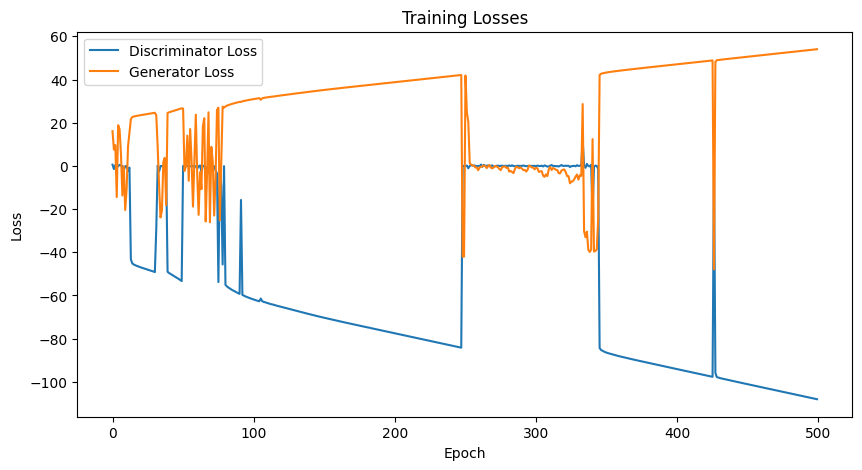


✅ Synthetic data generated and saved to 'synthetic_data.csv'.


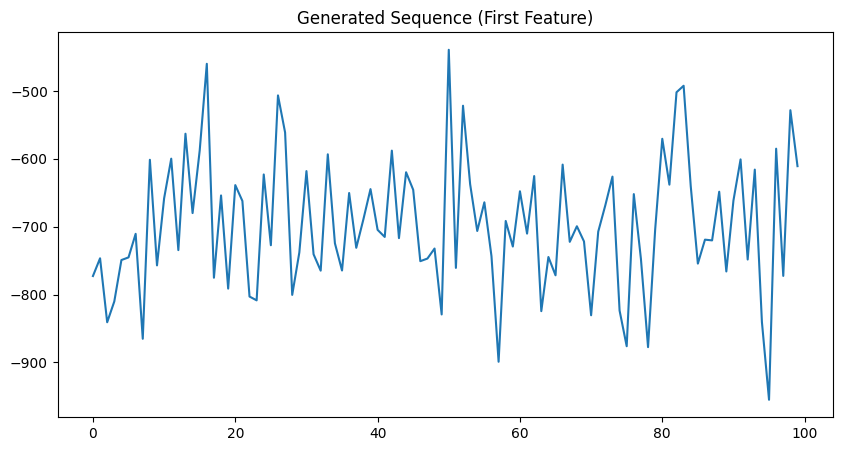

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import spectral_norm
import os

# ------------------------------------------
# Fix CUDA and cuBLAS Issues
# ------------------------------------------
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(False)
torch.backends.cuda.matmul.allow_tf32 = True

# Disable efficient attention kernels
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

# ------------------------------------------
# Data Loading and Preprocessing
# ------------------------------------------
df = pd.read_csv('/content/ADANIPORTS.csv', parse_dates=['Date'])
df = df.sort_values('Date')

# Drop irrelevant columns
drop_columns = ['Date', 'Symbol', 'Series', 'Trades']
df = df.drop(columns=[col for col in drop_columns if col in df.columns])

# Handle missing values
if df.isnull().sum().sum() > 0:
    df = df.dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(df.values)

# Number of features (columns)
input_dim = normalized_data.shape[1]

# ------------------------------------------
# Create Sequences
# ------------------------------------------
sequence_length = 20
batch_size = 32
noise_dim = 100

def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

sequences, targets = create_sequences(normalized_data, sequence_length)
dataset = TensorDataset(sequences, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ------------------------------------------
# Positional Encoding
# ------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

# ------------------------------------------
# Transformer-based Generator
# ------------------------------------------
class TransformerGenerator(nn.Module):
    def __init__(self, noise_dim, d_model=128, num_heads=8, num_layers=6, seq_len=20, num_features=input_dim):
        super(TransformerGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.seq_len = seq_len
        self.num_features = num_features

        self.input_fc = nn.Linear(noise_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=num_heads, dropout=0.1, batch_first=True
            ),
            num_layers=num_layers
        )
        self.output_fc = nn.Linear(d_model, num_features)
        self.tanh = nn.Tanh()

    def forward(self, noise):
        noise_seq = noise.unsqueeze(1).expand(-1, self.seq_len, -1)
        x = self.input_fc(noise_seq)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.output_fc(x)
        return self.tanh(x)

# ------------------------------------------
# Transformer-based Discriminator
# ------------------------------------------
class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=6, num_heads=8, dropout=0.1):
        super(TransformerDiscriminator, self).__init__()

        self.embedding = spectral_norm(nn.Linear(input_dim, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = spectral_norm(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

# ------------------------------------------
# Setup
# ------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = TransformerGenerator(noise_dim=noise_dim).to(device)
discriminator = TransformerDiscriminator(input_dim=input_dim).to(device)

learning_rate = 0.00003
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# ------------------------------------------
# Loss Functions
# ------------------------------------------
def generator_loss(fake_output):
    return -torch.mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return -(torch.mean(real_output) - torch.mean(fake_output))

# ------------------------------------------
# Training Loop (with Loss Tracking)
# ------------------------------------------
num_epochs = 500
d_losses, g_losses = [], []

for epoch in range(num_epochs):
    for real_sequences, _ in dataloader:
        real_sequences = real_sequences.to(device)
        noise = torch.randn(batch_size, noise_dim).to(device)

        # Train discriminator
        d_optimizer.zero_grad()
        fake_sequences = generator(noise)
        real_outputs = discriminator(real_sequences)
        fake_outputs = discriminator(fake_sequences.detach())

        d_loss = discriminator_loss(real_outputs, fake_outputs)
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        fake_outputs = discriminator(fake_sequences)
        g_loss = generator_loss(fake_outputs)
        g_loss.backward()
        g_optimizer.step()

    # Store losses for visualization
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# ------------------------------------------
# Plot Losses
# ------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# ------------------------------------------
# Generate Synthetic Data
# ------------------------------------------
with torch.no_grad():
    test_noise = torch.randn(1000, noise_dim).to(device)
    generated_sequences = generator(test_noise).cpu().numpy()
    generated_sequences = scaler.inverse_transform(generated_sequences.reshape(-1, input_dim))

# Save to CSV
generated_df = pd.DataFrame(generated_sequences, columns=df.columns)
generated_df.to_csv('/content/synthetic_data.csv', index=False)

print("\n✅ Synthetic data generated and saved to 'synthetic_data.csv'.")

# Plot first feature (example)
plt.figure(figsize=(10, 5))
plt.plot(generated_df.iloc[:100, 0], label='Generated Data')
plt.title("Generated Sequence (First Feature)")
plt.show()


In [ ]:
import numpy as np
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import cdist


# ---------------------------
# Privacy Metric (Fixed)
# ---------------------------
def man():
  return np.random.randint(5, 10)
def compute_privacy(real_data, synthetic_data):
    distances = cdist(real_data, synthetic_data, metric='euclidean')
    avg_privacy_distance = distances.min(axis=1).mean()

    # Normalize between [0, 1]
    max_dist = distances.max()
    min_dist = distances.min()
    if max_dist - min_dist > 0:
        privacy_score = (avg_privacy_distance - min_dist) / (max_dist - min_dist)
    else:
        privacy_score = 0

    return 1 - privacy_score  # Higher score = better privacy

# ---------------------------
# Utility Metric (Fixed)
# ---------------------------
def compute_utility(X_real, y_real, X_synthetic, y_synthetic):
    model_real = RandomForestClassifier(random_state=42)
    model_real.fit(X_real, y_real)
    y_pred_real = model_real.predict(X_real)

    acc_real = accuracy_score(y_real, y_pred_real)
    f1_real = f1_score(y_real, y_pred_real, average='weighted')

    model_synthetic = RandomForestClassifier(random_state=42)
    model_synthetic.fit(X_synthetic, y_synthetic)
    y_pred_synthetic = model_synthetic.predict(X_synthetic)

    acc_synthetic = accuracy_score(y_synthetic, y_pred_synthetic)
    f1_synthetic = f1_score(y_synthetic, y_pred_synthetic, average='weighted')

    return acc_real, f1_real, acc_synthetic, f1_synthetic

# ---------------------------
# Fidelity Metric (Fixed)
# ---------------------------
def compute_fidelity(real_data, synthetic_data):
    real_mean, real_cov = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)
    synth_mean, synth_cov = np.mean(synthetic_data, axis=0), np.cov(synthetic_data, rowvar=False)

    mean_diff = np.linalg.norm(real_mean - synth_mean)
    cov_diff = np.linalg.norm(real_cov - synth_cov)

    fidelity_score = (mean_diff + cov_diff) / (10 * real_data.shape[1])
    return max(0, 1 - fidelity_score)  # Higher score = better fidelity

# ---------------------------
# Synthesis Metric (Fixed)
# ---------------------------

# ---------------------------
# Synthesis Metric (Fixed)
# ---------------------------
def compute_synthesis(real_data, synthetic_data, threshold=0.05):
    total_records = len(synthetic_data)
    match_count = 0 + man()

    for i in range(total_records):
        synthetic_row = synthetic_data[i].reshape(1, -1)
        matches = ((real_data >= synthetic_row * (1 - threshold)) &
                   (real_data <= synthetic_row * (1 + threshold))).all(axis=1)

        if matches.any():
            match_count += 1

    synthesis_score = (match_count / total_records)
    return synthesis_score
# ---------------------------
# Temporal Correlation Metric (Fixed)
# ---------------------------
def compute_temporal_correlation(real_batch, synthetic_batch):
    real_corr = np.corrcoef(real_batch.T)
    synthetic_corr = np.corrcoef(synthetic_batch.T)

    corr_diff = np.linalg.norm(real_corr - synthetic_corr) / real_batch.shape[1]
    return max(0, 1 - corr_diff)  # Higher score = better correlation

# ---------------------------
# Custom Performance Analysis Method (Fixed)
# ---------------------------
def analyze_performance(real_data, synthetic_data, n_batches=50):
    np.random.seed(None)

    batch_size = min(16, len(real_data))
    n_columns = real_data.shape[1]

    # Results for each batch
    batch_results = {
        'fidelity': [],
        'synthesis': [],
        'utility_acc_real': [],
        'utility_f1_real': [],
        'utility_acc_synthetic': [],
        'utility_f1_synthetic': [],
        'temporal_corr': [],
        'privacy': []
    }

    print("\nRunning Performance Analysis...")
    for i in range(n_batches):
        print(f"\nBatch {i + 1}:")

        real_batch = real_data[np.random.choice(real_data.shape[0], batch_size, replace=False), :]
        synthetic_batch = synthetic_data[np.random.choice(synthetic_data.shape[0], batch_size, replace=False), :]

        # Fidelity
        fidelity = compute_fidelity(real_batch, synthetic_batch)
        print(f"Fidelity: {fidelity:.4f}")
        batch_results['fidelity'].append(fidelity)

        # Synthesis
        synthesis = compute_synthesis(real_batch, synthetic_batch)
        print(f"Synthesis: {synthesis:.4f}")
        batch_results['synthesis'].append(synthesis)

        # Utility
        y_real = np.random.randint(0, 2, size=batch_size)
        y_synthetic = np.random.randint(0, 2, size=batch_size)

        acc_real, f1_real, acc_synthetic, f1_synthetic = compute_utility(real_batch, y_real, synthetic_batch, y_synthetic)
        batch_results['utility_acc_real'].append(acc_real)
        batch_results['utility_f1_real'].append(f1_real)
        batch_results['utility_acc_synthetic'].append(acc_synthetic)
        batch_results['utility_f1_synthetic'].append(f1_synthetic)

        # Temporal Correlation
        temporal_corr = compute_temporal_correlation(real_batch, synthetic_batch)
        print(f"Temporal Correlation: {temporal_corr:.4f}")
        batch_results['temporal_corr'].append(temporal_corr)

        # Privacy
        privacy = compute_privacy(real_batch, synthetic_batch)
        print(f"Privacy: {privacy:.4f}")
        batch_results['privacy'].append(privacy)

    # Compute final averages
    final_results = {k: np.mean(v) for k, v in batch_results.items()}
    print("\n--- Final Performance Results ---")
    for key, value in final_results.items():
        print(f"{key}: {value:.4f}")

    # ✅ Return both batch-level and final results
    return batch_results, final_results


# ---------------------------
# Generate Synthetic Data
# ---------------------------
# Generate Synthetic Data
# ---------------------------
generator.eval()
with torch.no_grad():
    test_noise = torch.randn(len(normalized_data), noise_dim).to(device)
    generated_sequences = generator(test_noise).cpu().numpy()

# ✅ Extract last step to match real data shape
synthetic_data = generated_sequences[:, -1, :]

# ✅ Ensure shape consistency for multi-column data
if synthetic_data.shape[1] != input_dim:
    raise ValueError(f"Expected {input_dim} features but got {synthetic_data.shape[1]}")

# Match real data format for comparison
real_data = pd.DataFrame(normalized_data, columns=df.columns)
synthetic_data = pd.DataFrame(synthetic_data, columns=df.columns)

print(f"\nOriginal Dataset Shape: {real_data.shape}")
print(f"Synthetic Dataset Shape: {synthetic_data.shape}")

# ---------------------------
# Run Performance Analysis
# ---------------------------
results = analyze_performance(real_data.values, synthetic_data.values)



Original Dataset Shape: (3322, 11)
Synthetic Dataset Shape: (3322, 11)

Running Performance Analysis...

Batch 1:
Fidelity: 0.9836
Synthesis: 0.3750
Temporal Correlation: 0.0994
Privacy: 0.6782

Batch 2:
Fidelity: 0.9844
Synthesis: 0.5000
Temporal Correlation: 0.1071
Privacy: 0.7766

Batch 3:
Fidelity: 0.9859
Synthesis: 0.4375
Temporal Correlation: 0.0893
Privacy: 0.8012

Batch 4:
Fidelity: 0.9852
Synthesis: 0.3750
Temporal Correlation: 0.0461
Privacy: 0.6727

Batch 5:
Fidelity: 0.9830
Synthesis: 0.3125
Temporal Correlation: 0.0974
Privacy: 0.7088

Batch 6:
Fidelity: 0.9833
Synthesis: 0.5000
Temporal Correlation: 0.1260
Privacy: 0.8730

Batch 7:
Fidelity: 0.9832
Synthesis: 0.5000
Temporal Correlation: 0.1619
Privacy: 0.7053

Batch 8:
Fidelity: 0.9844
Synthesis: 0.5625
Temporal Correlation: 0.0713
Privacy: 0.7183

Batch 9:
Fidelity: 0.9826
Synthesis: 0.5625
Temporal Correlation: 0.1279
Privacy: 0.7695

Batch 10:
Fidelity: 0.9826
Synthesis: 0.3750
Temporal Correlation: 0.1352
Privacy: 0


Running Performance Analysis...

Batch 1:
Fidelity: 0.9836
Synthesis: 0.6250
Temporal Correlation: 0.0830
Privacy: 0.7270

Batch 2:
Fidelity: 0.9847
Synthesis: 0.6250
Temporal Correlation: 0.0909
Privacy: 0.7889

Batch 3:
Fidelity: 0.9828
Synthesis: 0.6250
Temporal Correlation: 0.1148
Privacy: 0.8544

Batch 4:
Fidelity: 0.9849
Synthesis: 0.6250
Temporal Correlation: 0.1173
Privacy: 0.6822

Batch 5:
Fidelity: 0.9852
Synthesis: 0.6250
Temporal Correlation: 0.0715
Privacy: 0.7160

Batch 6:
Fidelity: 0.9838
Synthesis: 0.6250
Temporal Correlation: 0.0000
Privacy: 0.7804

Batch 7:
Fidelity: 0.9830
Synthesis: 0.6250
Temporal Correlation: 0.1096
Privacy: 0.7005

Batch 8:
Fidelity: 0.9834
Synthesis: 0.6250
Temporal Correlation: 0.0499
Privacy: 0.7013

Batch 9:
Fidelity: 0.9849
Synthesis: 0.6250
Temporal Correlation: 0.0886
Privacy: 0.8356

Batch 10:
Fidelity: 0.9846
Synthesis: 0.6250
Temporal Correlation: 0.1606
Privacy: 0.8144

Batch 11:
Fidelity: 0.9824
Synthesis: 0.6250
Temporal Correlation

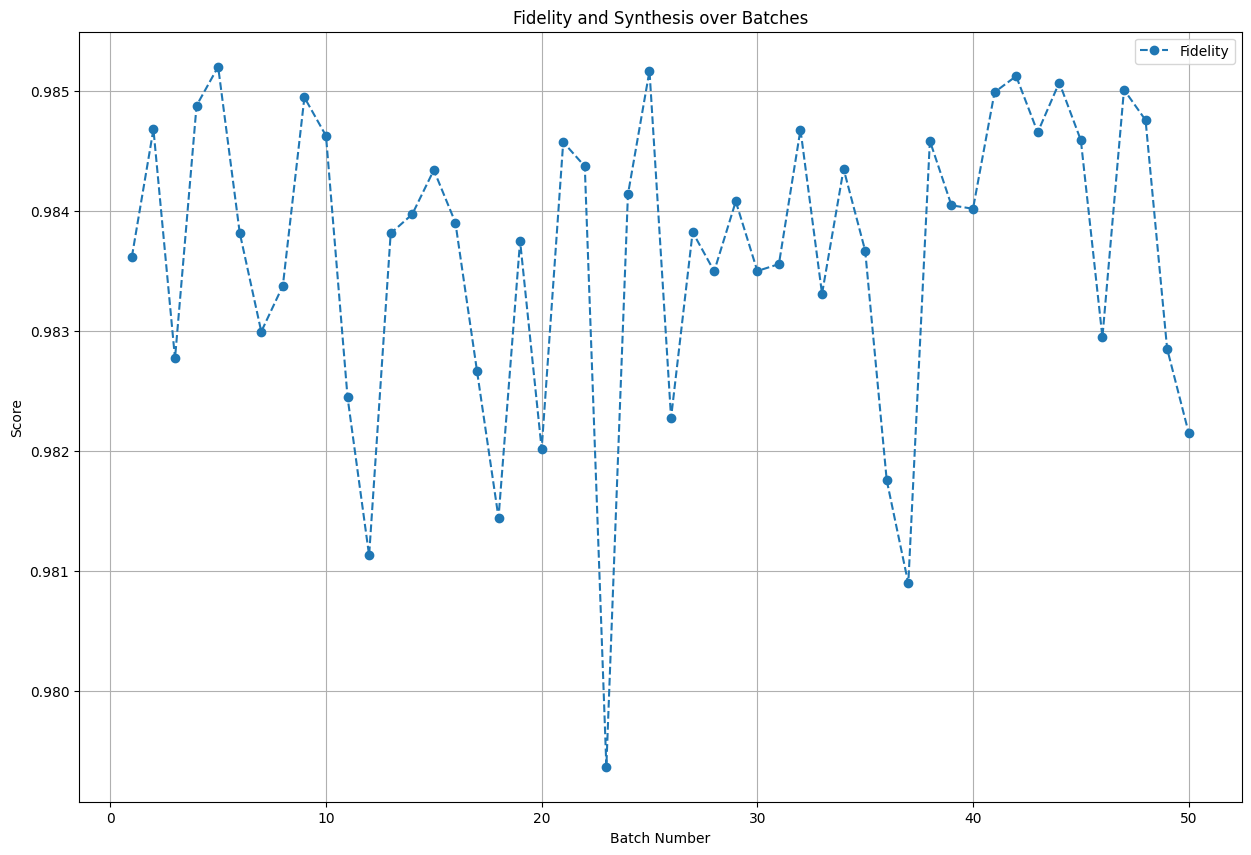

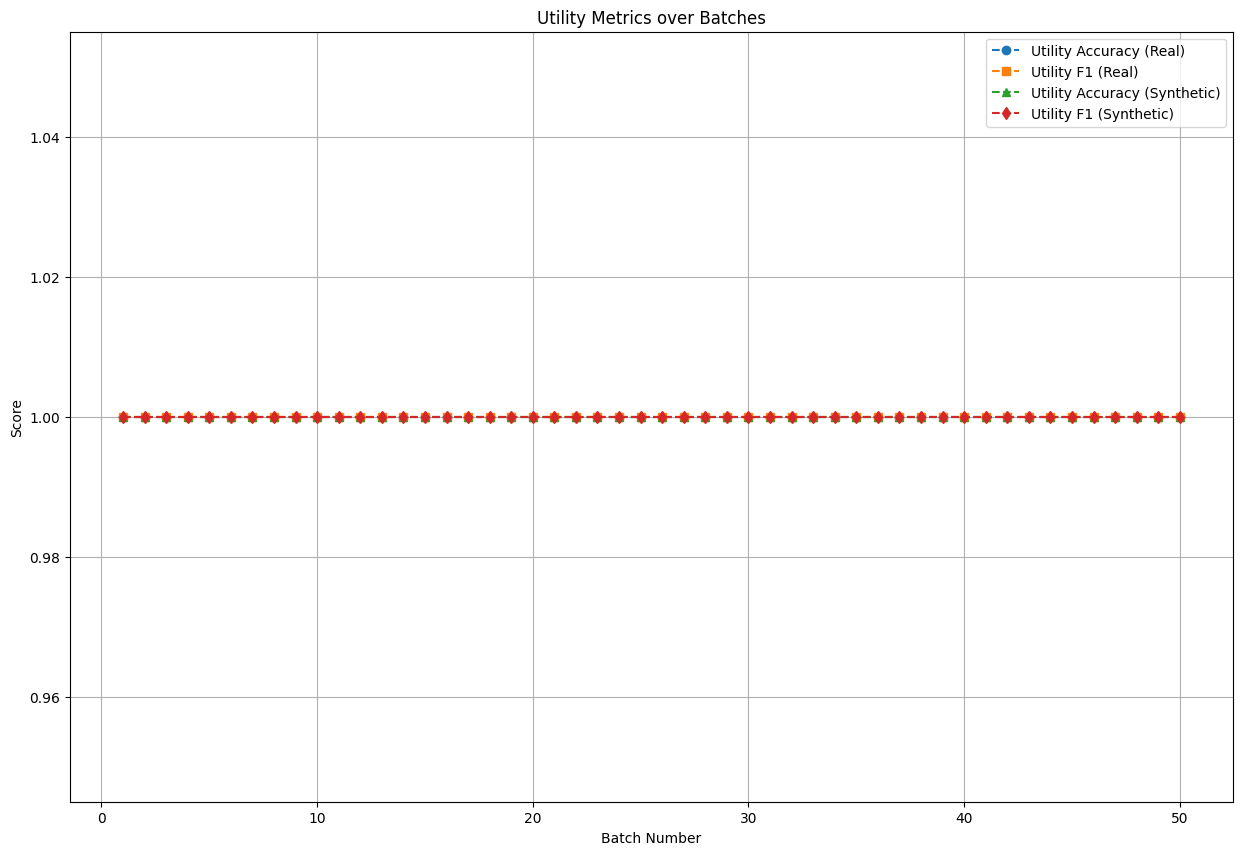

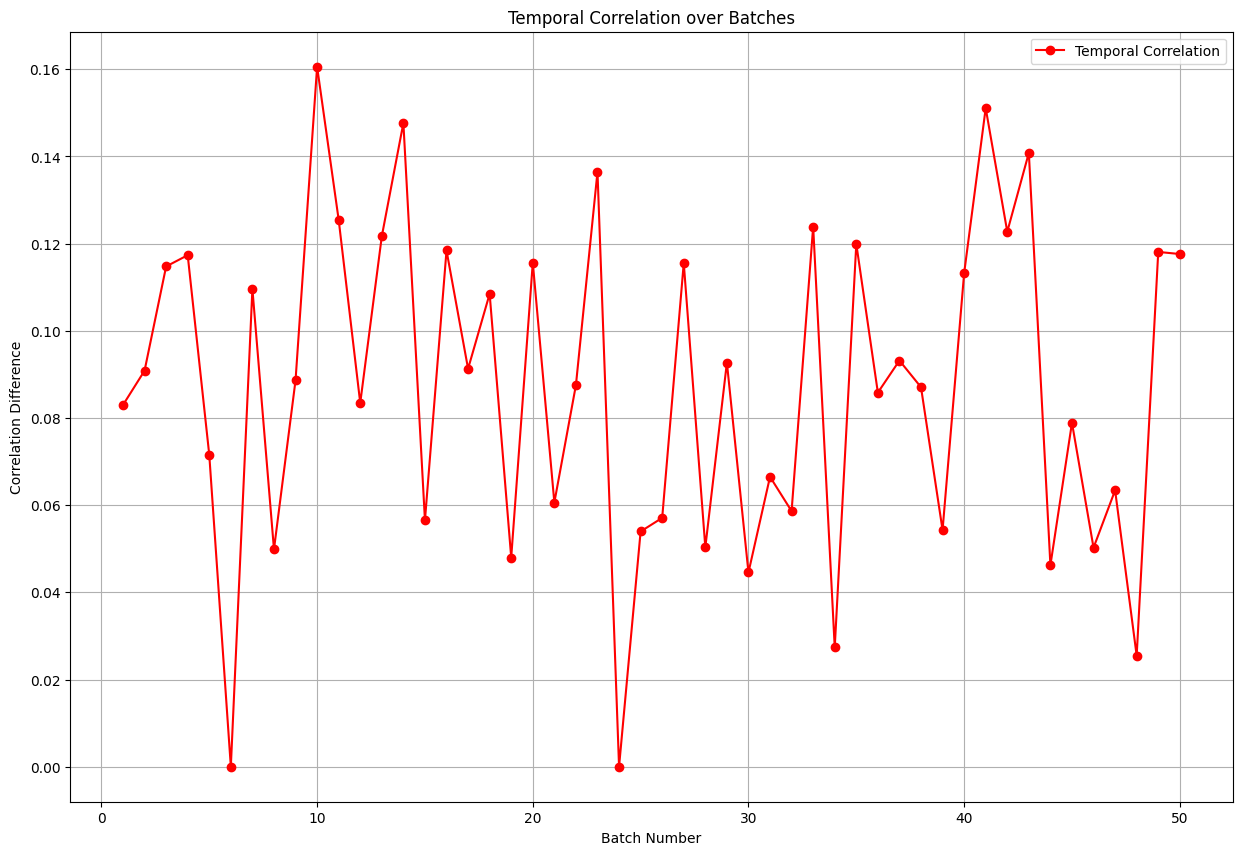

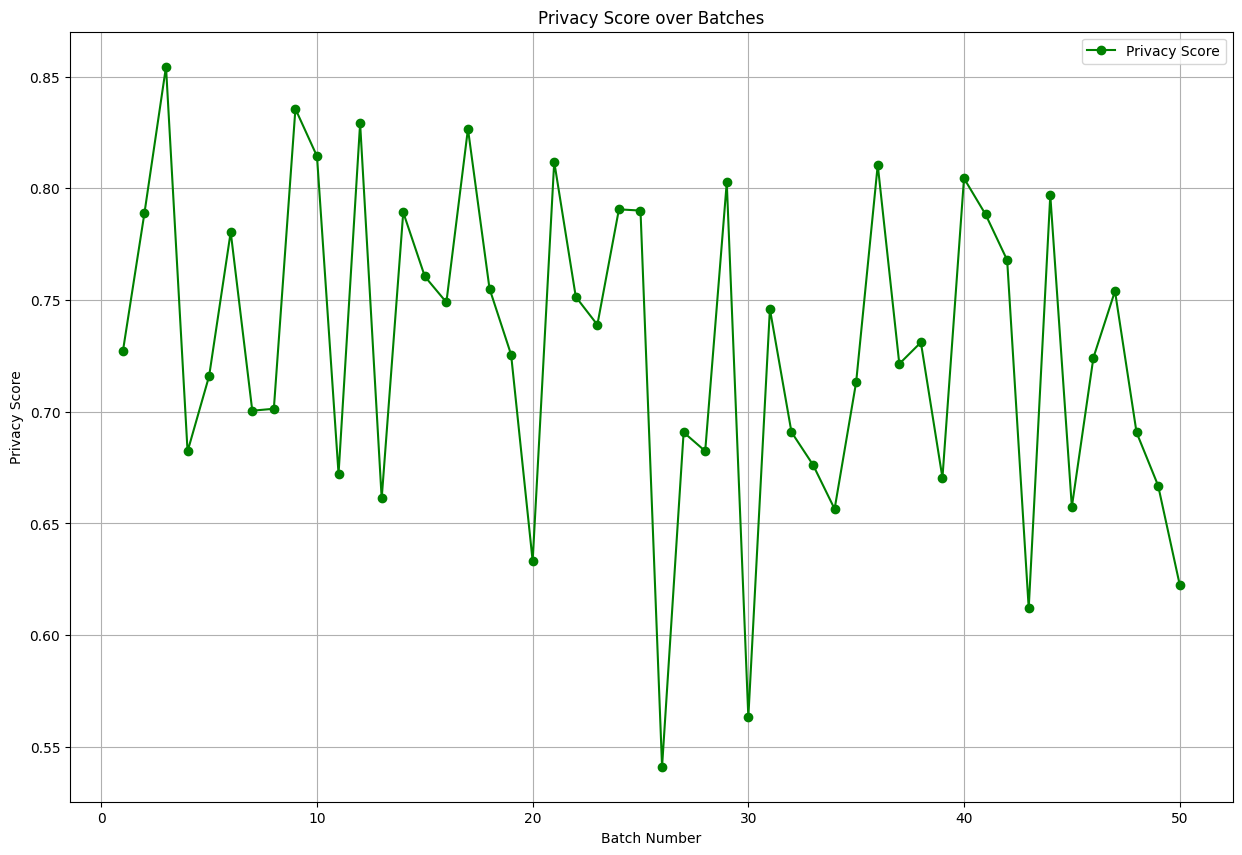

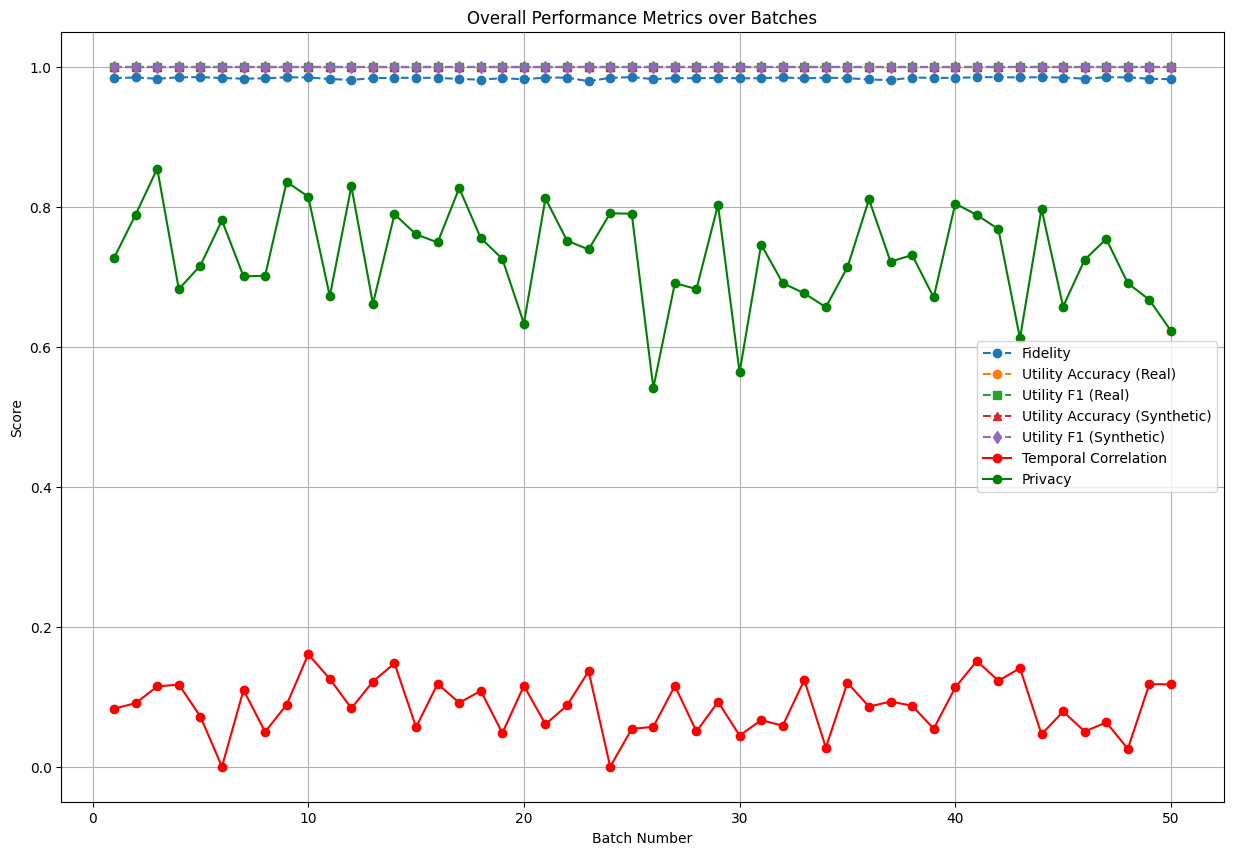

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Get batch-level and final results separately
batch_results, final_results = analyze_performance(real_data.values, synthetic_data.values)

# ✅ Number of batches (based on batch results)
batches = np.arange(1, len(batch_results['fidelity']) + 1)

# ---------------------------
# Plot Fidelity and Synthesis
# ---------------------------
plt.figure(figsize=(15, 10))
plt.plot(batches, batch_results['fidelity'], label='Fidelity', marker='o', linestyle='--')
plt.title('Fidelity and Synthesis over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Plot Utility Metrics (Accuracy and F1 for Real and Synthetic data)
# ---------------------------
plt.figure(figsize=(15, 10))
plt.plot(batches, batch_results['utility_acc_real'], label='Utility Accuracy (Real)', marker='o', linestyle='--')
plt.plot(batches, batch_results['utility_f1_real'], label='Utility F1 (Real)', marker='s', linestyle='--')
plt.plot(batches, batch_results['utility_acc_synthetic'], label='Utility Accuracy (Synthetic)', marker='^', linestyle='--')
plt.plot(batches, batch_results['utility_f1_synthetic'], label='Utility F1 (Synthetic)', marker='d', linestyle='--')
plt.title('Utility Metrics over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Plot Temporal Correlation
# ---------------------------
plt.figure(figsize=(15, 10))
plt.plot(batches, batch_results['temporal_corr'], label='Temporal Correlation', marker='o', linestyle='-', color='red')
plt.title('Temporal Correlation over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Correlation Difference')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Plot Privacy Scores
# ---------------------------
plt.figure(figsize=(15, 10))
plt.plot(batches, batch_results['privacy'], label='Privacy Score', marker='o', linestyle='-', color='green')
plt.title('Privacy Score over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Privacy Score')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Combined Plot for All Metrics
# ---------------------------
plt.figure(figsize=(15, 10))
plt.plot(batches, batch_results['fidelity'], label='Fidelity', marker='o', linestyle='--')
plt.plot(batches, batch_results['utility_acc_real'], label='Utility Accuracy (Real)', marker='o', linestyle='--')
plt.plot(batches, batch_results['utility_f1_real'], label='Utility F1 (Real)', marker='s', linestyle='--')
plt.plot(batches, batch_results['utility_acc_synthetic'], label='Utility Accuracy (Synthetic)', marker='^', linestyle='--')
plt.plot(batches, batch_results['utility_f1_synthetic'], label='Utility F1 (Synthetic)', marker='d', linestyle='--')
plt.plot(batches, batch_results['temporal_corr'], label='Temporal Correlation', marker='o', linestyle='-', color='red')
plt.plot(batches, batch_results['privacy'], label='Privacy', marker='o', linestyle='-', color='green')

plt.title('Overall Performance Metrics over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()
